In [ ]:
#https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48

In [23]:
from keras.applications import VGG16
model = VGG16(weights='imagenet')

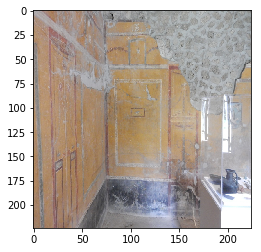

In [24]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np


# The local path to our target image
img_path = '/home/oj/Downloads/197.jpg'
# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))



#pick a sample image and preprocess
def preprocess(img):
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img
image_1 = preprocess(img)



import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [27]:
#make top 3 predictions
predict = model.predict(image_1)
print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

[[('n04553703', 'washbasin', 0.1478007), ('n04209239', 'shower_curtain', 0.083815366), ('n03207941', 'dishwasher', 0.051312055)]]
Target Class = 896


In [28]:
#gradients of the target class score yc with respect to the feature maps 
#Ak of the last convolutional layer. Intuitively it tells us how important 
#each channel is with regard to the target class.

import keras
from keras import backend as K
last_conv = model.get_layer('block5_conv3')
grads = K.gradients(model.output[:,896],last_conv.output)[0]

In [29]:
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([image_1])

In [30]:
for i in range(512):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

In [31]:
for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

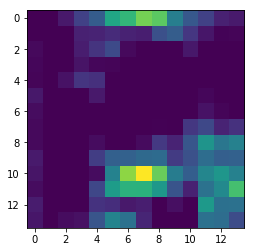

In [32]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

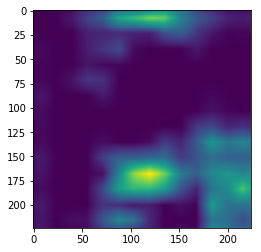

In [33]:
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import skimage.transform
upsample = img_as_ubyte(skimage.transform.resize(heatmap, (224, 224)))
plt.imshow(upsample)
plt.imshow(upsample,alpha=0.5)
plt.show()

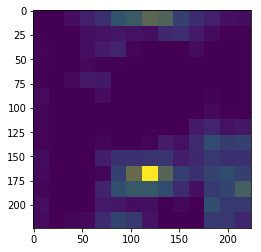

In [34]:
import cv2
#upsample = cv2.resize(heatmap, (224, 224))
upsample = cv2.resize(heatmap,(224,224),interpolation=cv2.INTER_AREA)
z = np.copy(upsample).astype('uint8')

plt.imshow(z)
plt.imshow(upsample,alpha=0.5)
plt.show()

In [35]:

import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('/home/oj/Downloads/197_cam_datascience.jpg', superimposed_img)

True